# Coastal Storm Hazard
This notebook calculates the urban risk index for Coastal Storm (CST)
hazard.  The URI calculation has three components: expected loss, social vulnerability, and resilience capacity.  

## 1. Expected Loss
The EXH hazard expected loss (EL) includes consequences for the following receptors and marginal losses.
 * Various / HAZUS losses
 * People / deaths

#### 1a. Various / HAZUS losses
Annualized HAZUS losses were provided for coastal storms including building, content, inventory, relocation cost,
income, rental, and wage categories.   

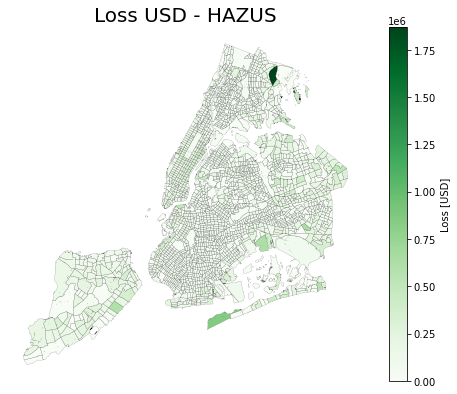

In [1]:
from MISC import params_1 as params
from MISC import utils_1 as utils
from MISC import plotting_1 as plotting
from CLASSES import class_EL_SV_CR_1 as URI
import matplotlib.pyplot as plt
import geopandas as gpd
import os
utils.set_home()
hazard_name = "CST"

#create ESL class and add loss
path_loss =   params.PATHNAMES.at['ESL_CST_hazus_loss', 'Value']
gdf_ESL_deaths = gpd.read_file(path_loss)
ESL = URI.ESL(hazard_name = hazard_name)
ESL.add_consequence("HAZUS", "Various", gdf_ESL_deaths)

#plot
plotting.plot_ESL_nb(hazard_name, ESL.consequence["HAZUS"]["map_tract"], 'Loss USD - HAZUS')

#### 1b. People / Deaths
The HH&C database was used to count the average of deaths due to "coastal storm" events over the past 20 years. The 
 HH&C database documented 43 deaths, all from Hurricane Sandy.  The 
deaths were valuated and distributed by population.  

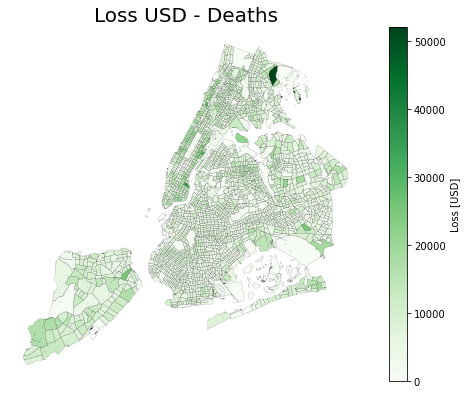

In [2]:
#all loss to ESL class
path_loss =   params.PATHNAMES.at['ESL_CST_deaths_loss', 'Value']
gdf_loss = gpd.read_file(path_loss)
ESL.add_consequence("Deaths", "People", gdf_loss)

#plot
plotting.plot_ESL_nb(hazard_name, ESL.consequence["Deaths"]["map_tract"], 'Loss USD - Deaths')


#### 1c. Expected Loss Total
The total expected losses are the sum of losses from each individual consequence.  

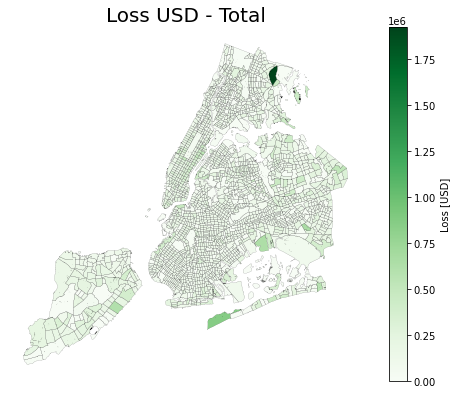

In [3]:
#total all consequences
ESL.calc_ESL_total()

#save result
path_save = params.PATHNAMES.at['OUTPUTS_folder', 'Value'] + r'\ESL\ESL_{}_tract.shp'.format(hazard_name, hazard_name)
ESL.ESL_map.to_file(path_save)

#plot
plotting.plot_ESL_nb(hazard_name, ESL.ESL_map, 'Loss USD - Total')


## 2. Social Vulnerability Score
The Social Vulnerability is based on the CDC SoVI score.

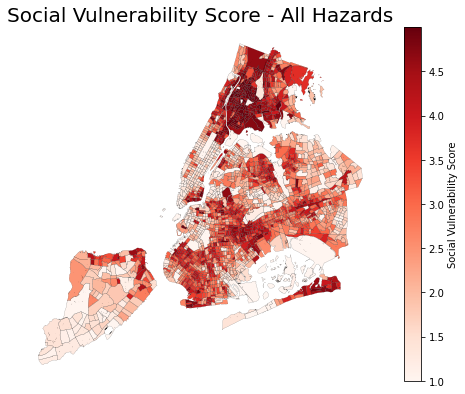

In [4]:
path_SOV = params.PATHNAMES.at['OUTPUTS_folder', 'Value'] + r'\\SOV\SOV_tract.shp'
gdf_SOV = gpd.read_file(path_SOV)
SOV = URI.SOV(hazard_name = hazard_name, map_tract = gdf_SOV)


#plot
plotting.plot_SOV_nb(SOV.SOV_map)

## 3. Resilience Capacity Score
The Resilience Capacity is the sum of four scores:
- Community capital
- Mitigation Landscape
- Response Capacity
- Recovery Resources


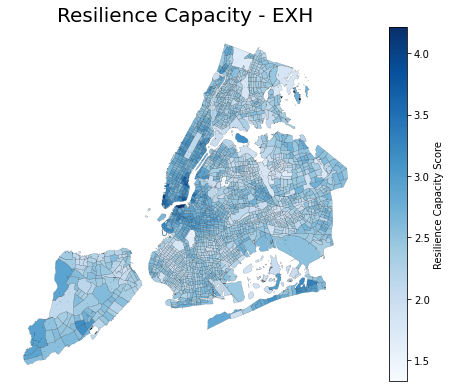

In [5]:
path_RCA = params.PATHNAMES.at['OUTPUTS_folder', 'Value'] + r'\\RCA\RCA_{}_tract.shp'.format(hazard_name)
gdf_RCA = gpd.read_file(path_RCA)
RCA = URI.RCA(hazard_name=hazard_name, map_tract=gdf_RCA)
# #plot
# fig = plt.figure(figsize=(10, 5))
# ax = fig.add_subplot(111)
# RCA.RCA_map.plot(ax=ax, column = 'RCA', legend=True)
# plt.axis('off')
# plt.title('Resilience Capacity Score')

#
plotting.plot_RCA_nb('EXH', RCA.RCA_map)

## 4. Calculate URI Score
The URI is ESL * SOV / RCA.  The result is clustered into a score of 1 (low) to 5 (high).

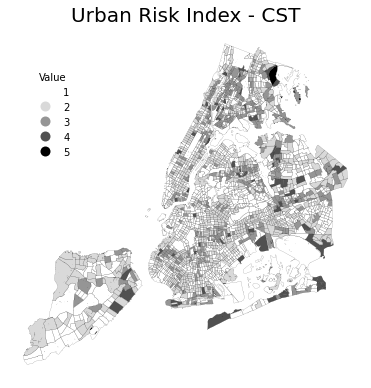

In [6]:
URI_HAZ = URI.URI(hazard_name=hazard_name, ESL=ESL, SOV=SOV, RCA=RCA)
URI_HAZ.calc_URI()

#save result
path_save = params.PATHNAMES.at['OUTPUTS_folder', 'Value'] + r'\URI\URI_{}_tract.shp'.format(hazard_name, hazard_name)
URI_HAZ.URI_map.to_file(path_save)


#plot
# fig = plt.figure(figsize=(10, 5))
# ax = fig.add_subplot(111)
# URI_EXH.URI_map.plot(ax=ax, column = 'URI', legend=True)
# plt.axis('off')
# plt.title('URI Score')
plotting.plot_URI_nb(hazard_name, URI_HAZ.URI_map)

#### Variation: Use per capita losses
Per capital losses can account for differences in population.

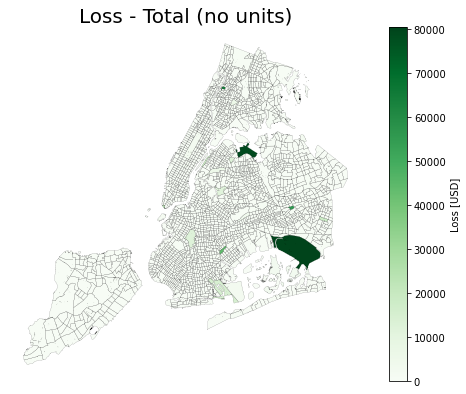

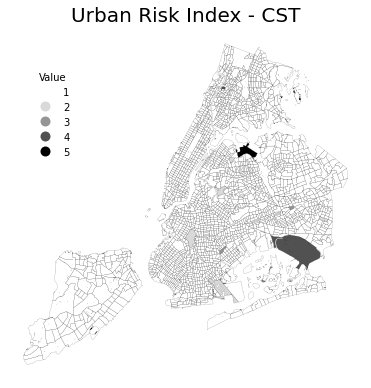

In [7]:
import copy
ESL_P = copy.copy(ESL)
ESL_P.ESL_map = utils.normalize_loss_by_population(ESL.ESL_map)
URI_EXH_P = URI.URI(hazard_name=hazard_name, ESL=ESL_P, SOV=SOV, RCA=RCA)
URI_EXH_P.calc_URI()
#plot
plotting.plot_ESL_nb(hazard_name, ESL_P.ESL_map, 'Loss - Total (no units)')
plotting.plot_URI_nb(hazard_name, URI_EXH_P.URI_map)

